In [1]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic ARIMA for Time Series

### **Overview**
The **Machine Gnostics ARIMA (AutoRegressive Integrated Moving Average)** extends the classic ARIMA model with **Gnostic Weighted Learning**. This makes the estimation of the AR, I, and MA components robust to outliers in the time series.

Key advantages:
- **Robustness**: Effectively handles outliers that would typically skew the autocorrelation structure.
- **Integrated (d)**: Supports differencing for non-stationary data.
- **Moving Average (q)**: Includes MA terms estimated via robust Gnostic regression.
- **Auto-Optimization**: Can automatically finding the best (p, d, q) order.

---

### **Theoretical Background**

The model estimates the parameters for:
$$ y'_t = c + \sum_{i=1}^p \phi_i y'_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t $$
where $y'_t$ is the differenced series.

The estimation uses **Iteratively Reweighted Least Squares** driven by Gnostic Entropy, ensuring that points with large, unexpected residuals (outliers) receive low weights during parameter fitting.

***

## Example 1: Robust ARIMA Forecasting

We create a synthetic time series that includes a trend, some autoregressive behavior, and significant outliers. We then fit a Gnostic ARIMA model to it.

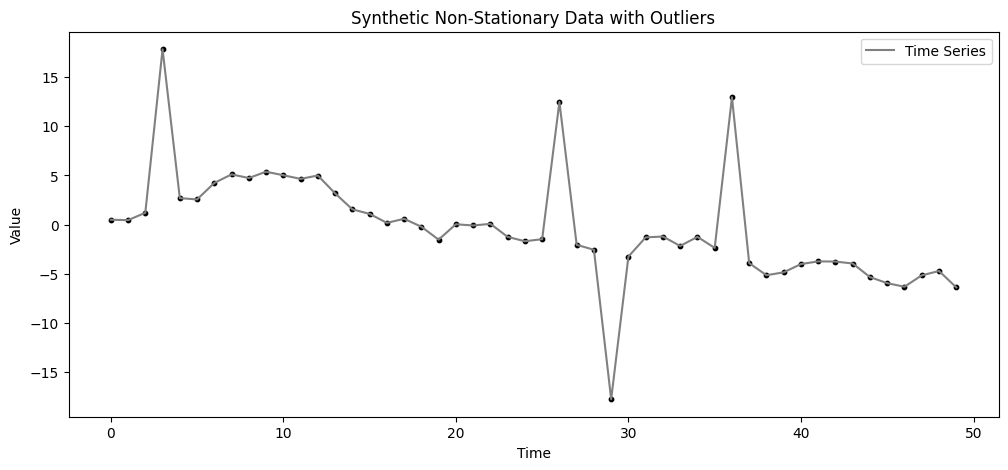

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from machinegnostics.models import ARIMA

# Generate Data
def generate_arima_data(n_samples=200, drift=0.1, outlier_prob=0.08, random_seed=42):
    """
    Generate a Random Walk with Drift + Outliers (ARIMA(0,1,0) + Trend + Noise)
    """
    np.random.seed(random_seed)
    t = np.arange(n_samples)
    
    # Random walk errors
    errors = np.random.normal(0, 1.0, n_samples)
    y = np.cumsum(errors) + (drift * t)
    
    # Add Outliers
    n_outliers = int(n_samples * outlier_prob)
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    
    # Add large spikes
    y[outlier_indices] += np.random.choice([-15, 15], n_outliers)
    
    return t, y

t, y = generate_arima_data(n_samples=50)

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(t, y, label='Time Series', color='gray')
plt.scatter(t, y, color='black', s=10)
plt.title("Synthetic Non-Stationary Data with Outliers")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [4]:
# Initialize and Train Gnostic ARIMA
# We use order=(1, 1, 0) assuming some AR behavior after differencing, or to check robustness.
# trend='c' allows for the drift.
model = ARIMA(
    order=(1, 1, 0), 
    trend='ct', 
    max_iter=50,
    verbose=False
)

print("Training Gnostic ARIMA...")
model.fit(y)

model.summary()

Training Gnostic ARIMA...
Gnostic ARIMA(p=1, d=1, q=0, trend='ct')
Iterations: 7
Final Weights Stats:
  Min: 0.0000
  Max: 0.0343
  Mean: 0.0208


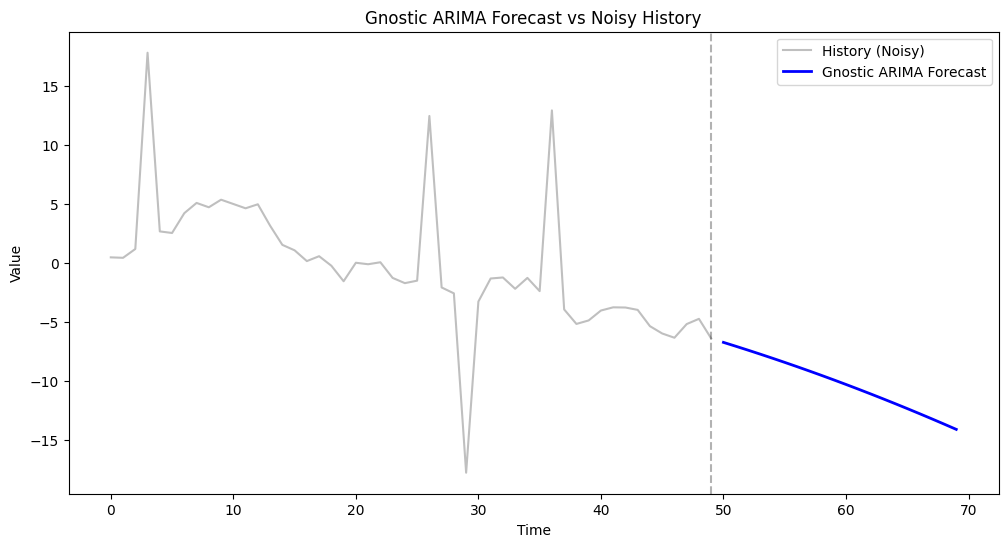

Forecast: [-6.70396506 -7.02897185 -7.36085761 -7.69973341 -8.04560025]...


In [5]:
# Forecast
steps = 20
forecast = model.predict(steps=steps)

# Plot Forecast
t_future = np.arange(len(t), len(t) + steps)

plt.figure(figsize=(12, 6))
plt.plot(t, y, color='gray', alpha=0.5, label='History (Noisy)')
plt.plot(t_future, forecast, color='blue', linewidth=2, label='Gnostic ARIMA Forecast')
plt.axvline(x=t[-1], color='k', linestyle='--', alpha=0.3)
plt.title("Gnostic ARIMA Forecast vs Noisy History")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

print(f"Forecast: {forecast[:5]}...")

## Example 2: Automatic Order Optimization

The `ARIMA` class can effectively search for the optimal `(p, d, q)` parameters that minimize error on a validation split. We set `optimize=True` to enable this feature.

In [6]:
# Initialize Auto-ARIMA
auto_model = ARIMA(
    optimize=True,
    max_order_search=(10, 1, 10), # Search space: p<=4, d<=1, q<=4
    trend='ct',
    verbose=True
)

print("Running AutoML for ARIMA (this may take a moment)...")
auto_model.fit(y)

print(f"Optimal Order Found: {auto_model.order}")

Running AutoML for ARIMA (this may take a moment)...
Optimal Order Found: (0, 0, 0)


## Example 3: Gnostic Weights Analysis

Visualization of how the model "sees" the data quality.
- **Yellow**: Reliable data points.
- **Purple**: Outliers (down-weighted).

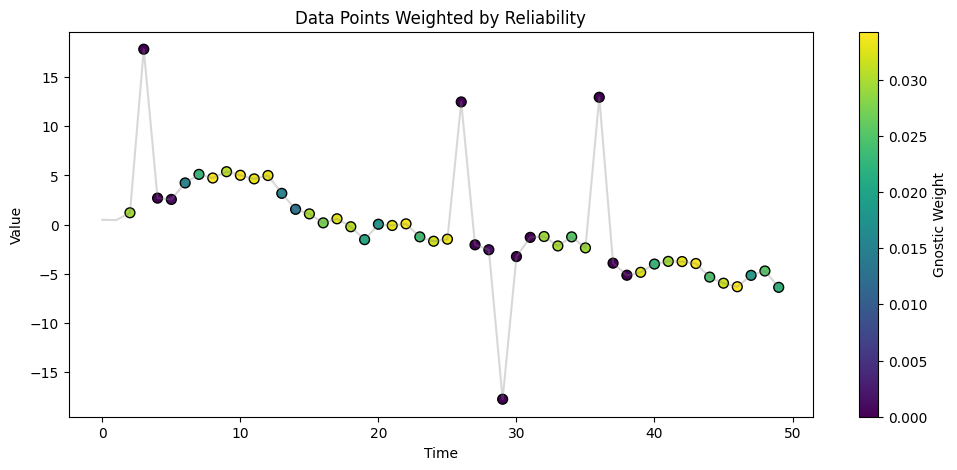

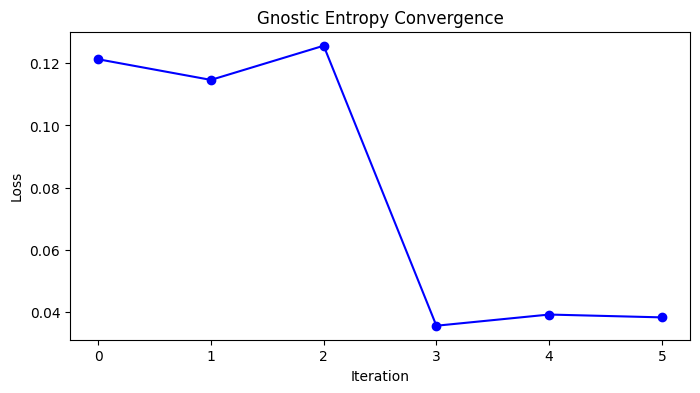

In [7]:
# We use the auto_model or the manually trained one
weights = model.weights

# Note: weights length corresponds to the effective training samples
# Typically len(y) - d - max(p,q)
valid_indices = range(len(y) - len(weights), len(y))

plt.figure(figsize=(12, 5))
plt.plot(t, y, color='gray', alpha=0.3)
sc = plt.scatter(t[valid_indices], y[valid_indices], c=weights, cmap='viridis', s=50, edgecolors='k')
plt.colorbar(sc, label='Gnostic Weight')
plt.title("Data Points Weighted by Reliability")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Show convergence
history = model._history
if history:
    losses = [h['rentropy'] for h in history if h['iteration'] is not None and h['rentropy'] is not None]
    if losses:
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(losses)), losses, 'b-o')
        plt.title("Gnostic Entropy Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()